In [8]:
import scipy.io as sio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

from iFEMG_feature import *

'''
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet  # 批量导入要实现的回归算法
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor  # 集成算法
from sklearn.model_selection import cross_val_score  # 交叉检验
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score  # 批量导入指标算法
'''
from sklearn.svm import SVR
# from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


import time
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# 更新iFEMG_feature.py工具包之后的单块肌肉信号处理分析代码

In [2]:
# load all experimental data in signal_df 
# file path format: 'D:\\folder path\\subject name\\label_(rest/active).mat'
file_folder_path = 'D:\code\data\iFEMG_data_set'
subjects = ['\zpk1', '\zpk2', '\zpk3', '\zpk4', '\zpk5', '\zpk6']
mat_name = ['d0', 'd2', 'd5', 'd7', 'dm']

signal_df = pd.DataFrame(columns = ('subject_name', 'rest_signal', 'active_signal', 'label', 'sensor_channel'))
# rest/active signal: [:, 0]FMG, [:, 1]sEMG

for i in subjects:
    for j in mat_name:
        # print('processing: ', i + j)
        # build data frame, every row has a unique label
        signal_df = signal_df.append({'subject_name' : i,
                                    'rest_signal': sio.loadmat(file_folder_path + i + '\\' + j + '_rest.mat')[j + '_rest'],
                                    'active_signal': sio.loadmat(file_folder_path + i + '\\' + j + '_active.mat')[j + '_active'], 
                                    'label' : j,
                                    'sensor_channel' : 'bicps_br'}, ignore_index=True)
    pass

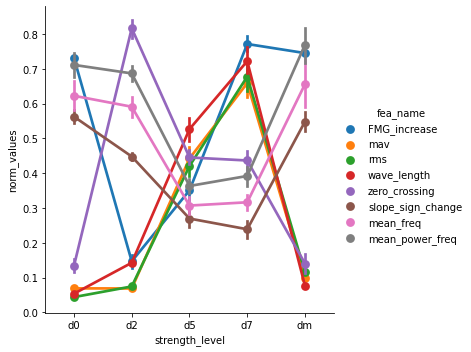

In [3]:
'''
1st index: subjects
2nd index: force level
3rd index: sensor channel
FMG + sEMG + ultrasound
'''
'''
feature name:
    FMG_increase
    sEMG:
        mav
        rms
        wave_length
        zero_crossing
        slope_sign_change
        mean_freq
        mean_power_freq
'''
# init a dataframe to store features
# get feature dataframe
sb_feature_df =pd.DataFrame(columns=('subject_name', 'label', 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq'))

# 使用boolean值索引出某一名受试者的实验数据
sb_data = signal_df.loc[signal_df.loc[:, 'subject_name'] == '\zpk2']
# 计算一名被试的所有特征
for row in sb_data.itertuples():
    # init data object
    FMG = FMGFeature(row.rest_signal[:, 0], row.active_signal[:, 0], 1223)
    sEMG = sEMGFeature(row.rest_signal[:, 1], row.active_signal[:, 1], 1223)
    # set window_length and step_increase
    FMG.signal_segment(2446, 500)
    sEMG.signal_segment(2446, 500)
    # print(row.label)
    temp_FMG_fea = FMG.FMG_increase()
    temp_mav = sEMG.feature_mav()
    temp_rms = sEMG.feature_rms()
    temp_wl = sEMG.feature_wl()
    temp_zc = sEMG.feature_zc()
    temp_ssc = sEMG.feature_ssc()
    temp_sEMG_freq_fea = sEMG.freq_features()
    temp_len = len(temp_FMG_fea)
    for i in range(temp_len):
        sb_feature_df = sb_feature_df.append({'subject_name': row.subject_name,
                                            'label': row.label,
                                            'FMG_increase': temp_FMG_fea[i],
                                            'mav': temp_mav[i],
                                            'rms': temp_rms[i],
                                            'wave_length': temp_wl[i],
                                            'zero_crossing': temp_zc[i],
                                            'slope_sign_change': temp_ssc[i],
                                            'mean_freq': temp_sEMG_freq_fea[i][0],
                                            'mean_power_freq': temp_sEMG_freq_fea[i][1]}, ignore_index=True)
        pass
    pass

# signal features normalization
sb_fea_norm_df = fea_df_norm(sb_feature_df, 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq')

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for row in sb_fea_norm_df.itertuples():    # go through each row
    for i in ['FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']:
        show_df = show_df.append({'subject': row.subject_name,
                                'strength_level': row.label,
                                'norm_values': getattr(row, i),
                                'fea_name': i}, ignore_index=True)

sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'point')

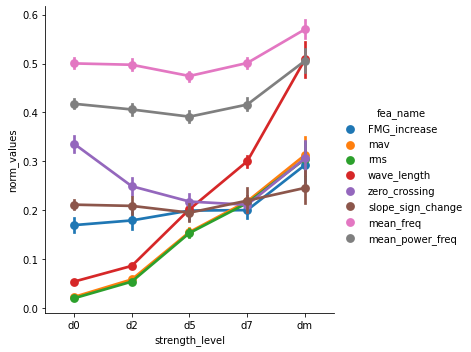

In [3]:
# 处理所有数据
all_feature_df =pd.DataFrame(columns=('subject_name', 'label', 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq'))

for row in signal_df.itertuples():
    FMG = FMGFeature(row.rest_signal[:, 0], row.active_signal[:, 0], 1223)
    sEMG = sEMGFeature(row.rest_signal[:, 1], row.active_signal[:, 1], 1223)
    FMG.signal_segment(1223, 500)
    sEMG.signal_segment(1223, 500)
    # print(row.label)
    temp_FMG_fea = FMG.FMG_increase()
    temp_mav = sEMG.feature_mav()
    temp_rms = sEMG.feature_rms()
    temp_wl = sEMG.feature_wl()
    temp_zc = sEMG.feature_zc()
    temp_ssc = sEMG.feature_ssc()
    temp_sEMG_freq_fea = sEMG.freq_features()
    temp_len = len(temp_FMG_fea)
    for i in range(temp_len):
        all_feature_df = all_feature_df.append({'subject_name': row.subject_name,
                                            'label': row.label,
                                            'FMG_increase': temp_FMG_fea[i],
                                            'mav': temp_mav[i],
                                            'rms': temp_rms[i],
                                            'wave_length': temp_wl[i],
                                            'zero_crossing': temp_zc[i],
                                            'slope_sign_change': temp_ssc[i],
                                            'mean_freq': temp_sEMG_freq_fea[i][0],
                                            'mean_power_freq': temp_sEMG_freq_fea[i][1]}, ignore_index=True)
        pass
    pass
# normalization
all_fea_norm_df = fea_df_norm(all_feature_df, 'FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq')

# show figure
show_df = pd.DataFrame(columns = ('subject', 'strength_level', 'norm_values', 'fea_name'))

for row in all_fea_norm_df.itertuples():    # go through each row
    for i in ['FMG_increase', 'mav', 'rms', 'wave_length', 'zero_crossing', 'slope_sign_change', 'mean_freq', 'mean_power_freq']:
        show_df = show_df.append({'subject': row.subject_name,
                                'strength_level': row.label,
                                'norm_values': getattr(row, i),
                                'fea_name': i}, ignore_index=True)

sns.catplot(x = "strength_level",
            y = "norm_values",
            hue = "fea_name",
            data = show_df,
            kind = 'point')

In [12]:
# SVM model


# 使用boolean值索引出每种label对应的实验数据
# 排除第一列受试者名称和第二列label字符串
d0_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd0'].values[:, 2:]
d2_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd2'].values[:, 2:]
d5_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd5'].values[:, 2:]
d7_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd7'].values[:, 2:]
dm_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'dm'].values[:, 2:]

# 创建数据集和label
f_data = []
label = []
#    data = []
#    l_sit = np.zeros((f_sit.shape[0], 1))
#    l_stand = np.zeros((f_stand.shape[0], 1))
#    l_walk = np.zeros((f_walk.shape[0], 1))
#    l_stairA = np.zeros((f_stairA.shape[0], 1))
#    l_stairD = np.zeros((f_stairD.shape[0], 1))
#    l_rampA = np.zeros((f_rampA.shape[0], 1))
#    l_rampD = np.zeros((f_rampD.shape[0], 1))

for i in range(d0_data.shape[0]):
    label.append(0)

for i in range(d2_data.shape[0]):
    label.append(1)

for i in range(d5_data.shape[0]):
    label.append(2)

for i in range(d7_data.shape[0]):
    label.append(3)

for i in range(dm_data.shape[0]):
    label.append(4)

f_data = np.concatenate((d0_data, d2_data, d5_data, d7_data, dm_data), axis = 0)
print("data shape： ", f_data.shape)
print("label num: ", len(label))

# 划分训练集和测试集
train_data_r, test_data_r, train_label, test_label = train_test_split(f_data, label, test_size = 0.2, random_state = 0, stratify = label)
# train_data = preprocessing.normalize(train_data_r, norm = 'max')
# test_data = preprocessing.normalize(test_data_r, norm = 'max')
scaler = preprocessing.StandardScaler().fit(train_data_r)
train_data = scaler.transform(train_data_r)
test_data = scaler.transform(test_data_r)

# 记录开始训练时间
start_time = time.time()
print("start training, time: ", time.strftime("%Y--%m--%d %H:%M:%S", time.localtime(start_time)))

parameters = {'gamma':[0.001, 0.01, 0.1, 1], 'C':np.linspace(1, 100, 100)}
gs = GridSearchCV(svm.SVC(), parameters, refit = True, cv = 5, verbose = 1, n_jobs = -1)
gs.fit(train_data, train_label)
print('best parameter: ', gs.best_params_)
print('best efficience:', gs.best_score_)
print('report: ', classification_report(test_label, gs.predict(test_data)))


c = svm.SVC(C = gs.best_params_['C'], kernel = 'rbf', gamma = gs.best_params_['gamma'], decision_function_shape = 'ovr')# 
c.fit(train_data, train_label)
print("train acc:", c.score(train_data, train_label))
print('test acc:', c.score(test_data, test_label))
test_pred = c.predict(test_data)
print(confusion_matrix(test_label, test_pred))

end_time = time.time()
print("finish, time: ", time.strftime("%Y--%m--%d %H:%M:%S", time.localtime(end_time)))

'''
knn = KNeighborsClassifier()
knn.fit(train_data, train_label)
print(knn.score(train_data, train_label))
print(knn.score(test_data, test_label))

test_pred = knn.predict(test_data)
name = ['sit', 'stand', 'walk', 'stairA', 'stairD', 'rampA', 'rampD']
print(confusion_matrix(test_label, test_pred))
'''



data shape：  (2130, 8)
label num:  2130
start training, time:  2022--09--25 17:29:39
Fitting 5 folds for each of 400 candidates, totalling 2000 fits
best parameter:  {'C': 17.0, 'gamma': 1}
best efficience: 0.9753613938243919
report:                precision    recall  f1-score   support

           0       0.98      0.97      0.97        88
           1       1.00      1.00      1.00        93
           2       0.96      0.96      0.96       103
           3       0.96      0.97      0.96        98
           4       0.95      0.95      0.95        44

    accuracy                           0.97       426
   macro avg       0.97      0.97      0.97       426
weighted avg       0.97      0.97      0.97       426

train acc: 0.9964788732394366
test acc: 0.971830985915493
[[85  0  1  0  2]
 [ 0 93  0  0  0]
 [ 0  0 99  4  0]
 [ 0  0  3 95  0]
 [ 2  0  0  0 42]]
finish, time:  2022--09--25 17:30:01


"\nknn = KNeighborsClassifier()\nknn.fit(train_data, train_label)\nprint(knn.score(train_data, train_label))\nprint(knn.score(test_data, test_label))\n\ntest_pred = knn.predict(test_data)\nname = ['sit', 'stand', 'walk', 'stairA', 'stairD', 'rampA', 'rampD']\nprint(confusion_matrix(test_label, test_pred))\n"

ValueError: x and y must be the same size

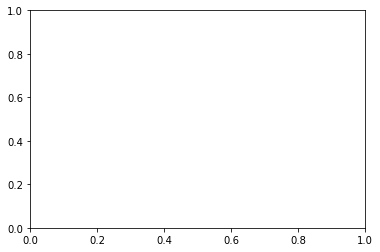

In [15]:
# SVR回归模型


# rng = np.random
# svr = joblib.load('svr.pkl')        # 读取模型

# x = rng.uniform(1, 100, (100, 1))
# y = 5 * x + np.sin(x) * 5000 + 2 + np.square(x) + rng.rand(100, 1) * 5000

# 自动选择合适的参数
svr = GridSearchCV(SVR(), param_grid={"kernel": ("linear", 'rbf'), "C": np.logspace(-3, 3, 7), "gamma": np.logspace(-3, 3, 7)})
svr.fit(train_data, train_label)
# joblib.dump(svr, 'svr.pkl')        # 保存模型

# xneed = np.linspace(0, 100, 100)[:, None]
xneed = test_data
y_pre = svr.predict(xneed)# 对结果进行可视化：
plt.scatter(train_data, train_label, c='k', label='data', zorder=1)
# plt.hold(True)
plt.plot(xneed, y_pre, c='r', label='SVR_fit')
plt.xlabel('data')
plt.ylabel('target')
plt.title('SVR versus Kernel Ridge')
plt.legend()
plt.show()
print(svr.best_params_)


In [17]:
from sklearn.metrics import mean_squared_error
# print(svr.best_params_)
# {'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}

score_test = svr.score(test_data, test_label)
score_train = svr.score(train_data, train_label)
print(str(svr) + "train score： " + str(score_train))
print(str(svr) + "test score： " + str(score_test))
test_pre = svr.predict(test_data)
train_pre = svr.predict(train_data)
print("train mean squared error: ", mean_squared_error(train_label, train_pre))
print("test mean squared error: ", mean_squared_error(test_label, test_pre))

{'C': 1000.0, 'gamma': 1.0, 'kernel': 'rbf'}


In [9]:
# 可独立运行的SVRmodel

# 使用boolean值索引出每种label对应的实验数据
# 排除第一列受试者名称和第二列label字符串
d0_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd0'].values[:, 2:]
d2_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd2'].values[:, 2:]
d5_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd5'].values[:, 2:]
d7_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'd7'].values[:, 2:]
dm_data = all_feature_df.loc[all_feature_df.loc[:, 'label'] == 'dm'].values[:, 2:]

# 创建数据集和label
f_data = []
label = []
#    data = []
#    l_sit = np.zeros((f_sit.shape[0], 1))
#    l_stand = np.zeros((f_stand.shape[0], 1))
#    l_walk = np.zeros((f_walk.shape[0], 1))
#    l_stairA = np.zeros((f_stairA.shape[0], 1))
#    l_stairD = np.zeros((f_stairD.shape[0], 1))
#    l_rampA = np.zeros((f_rampA.shape[0], 1))
#    l_rampD = np.zeros((f_rampD.shape[0], 1))

for i in range(d0_data.shape[0]):
    label.append(0)

for i in range(d2_data.shape[0]):
    label.append(1)

for i in range(d5_data.shape[0]):
    label.append(2)

for i in range(d7_data.shape[0]):
    label.append(3)

for i in range(dm_data.shape[0]):
    label.append(4)

f_data = np.concatenate((d0_data, d2_data, d5_data, d7_data, dm_data), axis = 0)
print("data shape： ", f_data.shape)
print("label num: ", len(label))

# 划分训练集和测试集
train_data_r, test_data_r, train_label, test_label = train_test_split(f_data, label, test_size = 0.2, random_state = 0, stratify = label)
# train_data = preprocessing.normalize(train_data_r, norm = 'max')
# test_data = preprocessing.normalize(test_data_r, norm = 'max')
scaler = preprocessing.StandardScaler().fit(train_data_r)
train_data = scaler.transform(train_data_r)
test_data = scaler.transform(test_data_r)

# 记录开始训练时间
start_time = time.time()
print("start training, time: ", time.strftime("%Y--%m--%d %H:%M:%S", time.localtime(start_time)))


regression_model = SVR(kernel='rbf', C=1000, gamma=1)
regression_model.fit(train_data, train_label)

end_time = time.time()
print("finish, time: ", time.strftime("%Y--%m--%d %H:%M:%S", time.localtime(end_time)))

data shape：  (2130, 8)
label num:  2130
start training, time:  2022--09--30 15:13:05
finish, time:  2022--09--30 15:13:07


In [12]:
import joblib
joblib.dump(regression_model, 'OneChannelRegression.pkl')


['OneChannelRegression.pkl']